In [1]:
##################################
### Import the usual libraries ###
##################################

### Other
import warnings
warnings.filterwarnings('ignore')

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

In [13]:
import numpy as np
import astropy
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import InterpolatedUnivariateSpline

# def closest(data,value):
#     '''
#     Find nearest value in array to given value
        
#     Inputs:
#     ------
#         data: data to search through 
#         value: value of interest
        
#     Output:
#     ------
#         close_value
#     '''
    
#     #value = np.asarray(value)
#     data = np.asarray(data)
    
#     close_value = data[(np.abs(np.subtract(data,value))).argmin()]
#     return close_value

# def neighbors(data,value):
#     '''
#     Find values of two elements closest to the given value
    
#     Inputs:
#     ------
#         data: data to search through 
#         value: value of interest
        
#     Output:
#     ------
#         close1: closest value under the given value
#         close2: closest value over the given value
#     '''
    
# #     value = np.asarray(value)
#     data = np.asarray(data)
    
#     close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    
#     data = data[np.where(data!=close1)]
    
#     close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
#     return close1,close2

In [14]:
def closest(arr,val):
    '''
    Find nearest neighbor to val in arr
    
    Inputs:
    ------
        arr: data to search through
        val: value of interest
    
    Output:
    ------
        closest neighbor
    '''
    arr = np.asarray(arr)
    return arr[(np.abs(np.subtract(arr,val))).argmin()]

def neighbors(arr,val):
    '''
    Find nearest neighbors to val in arr
    
    '''
    arr = np.asarray(arr)
    neigh1 = arr[(np.abs(np.subtract(arr,val))).argmin()]
    arr = arr[np.where(arr!=neigh1)]
    neigh2 = arr[(np.abs(np.subtract(arr,val))).argmin()]
    return neigh1,neigh2

In [27]:
class WhatsMyAgeAgain():
    '''
    Class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989
    '''
    def __init__(self,feh,am,distance,isochrones):
        
        '''
        feh: [float] metallicity of star
        am: [float] [$\alpha$/M] of star
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        '''
        
        # stellar parameters
        self.feh = feh
        self.salfeh = feh+np.log10(0.638*(10**am)+0.362) #Salaris et al. 1993
        self.dist = distance
        
        # PARSEC isochrones
        self.jlabel = 'Jmag'
        self.hlabel = 'Hmag'
        self.klabel = 'Ksmag'
        self.uniq_ages = 10**np.unique(isochrones['logAge'])/10**9
        self.iso = isochrones
        
        # Effective Wavelengths of different passbands
        self.leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons
        
    def car_a(self,x):
        '''
        a(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value 
        '''
        
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a
            
    def car_b(self,x):
        '''
        b(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
            
    def car_alak(self,wave):
        '''
        Calculate the relative extinction with the K band as the fiducial band and
        Rv (=Av/E(B_V)) = 3.1
        
        Input:
        -----
            wave: effective wavelength of band in microns
        
        Output:
        ------
            alak: extinction relative to the K band
        '''
        
        x=1/wave
        alak = (3.1*self.car_a(x)+self.car_b(x))/(3.1*self.car_a(1/2.1757)+self.car_b(1/2.1757))
        
        return alak
    
    def ind_alak(self,wave):
        '''
        Calculate the relative extinction to Ak using Indebetouw et al. 2005.
        This uses GLIMPSE data and has only been verified in IR.
    
        Input:
        -----
            wave: effective wavelength in microns of the passband
        
        Output:
        ------
            alak: A\lambda/Ak
        '''
        # 0.61 +/- 0.04; -2.22 +/- 0.17; 1.21 +/- 0.23
        alak = 10**(0.61-2.22*np.log10(wave)+1.21*(np.log10(wave)**2))
        return alak
        
    def Teff2AppMags(self,teff,age,ak):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: temperature of star
            age: age of star
            al: extinction in the same band used to initialize the class
            
            # parameters defined in __init__
            self.dist: distance to star
            self.iso: set of PARSEC isochrones
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        lgteff = np.log10(teff)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if age in self.uniq_ages:
            
#             print('in: ',age)
            
            # pick out a single isochrone 
            iso_ = self.iso[np.where((self.iso['logAge']==closest(self.iso['logAge'],np.log10(age*10**9)))&
                                       (self.iso['MH']==closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            
            sj = iso_[self.jlabel][sidx]
            sh = iso_[self.hlabel][sidx]
            sk = iso_[self.klabel][sidx]
            
            # splines for each apparent magnitude as function of teff
            _, uidx = np.unique(slogTe,return_index=True)
            
            j_spl = InterpolatedUnivariateSpline(slogTe[uidx],sj[uidx])
            h_spl = InterpolatedUnivariateSpline(slogTe[uidx],sh[uidx])
            k_spl = InterpolatedUnivariateSpline(slogTe[uidx],sk[uidx])
            
            j_app = j_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*self.car_alak(self.leff['J'])
            h_app = h_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak*self.car_alak(self.leff['H'])
            k_app = k_spl(lgteff)+5.0*np.log10(self.dist)-5.0+ak
            
#             print('Calculated Apparent J: {:.3f} H: {:.3f} K: {:.3f}'.format(j_app,h_app,k_app))
#             print('ak: {:.3f}'.format(ak))
#             print('---')
            
            return j_app,h_app,k_app
            
        else:
            age_lo,age_hi = neighbors(self.uniq_ages,age)
            
#             print('age: ',age)
            
            ### age_lo ###
            # pick out a single isochrone 
            iso_lo = self.iso[np.where((self.iso['logAge']==closest(self.iso['logAge'],np.log10(age_lo*10**9)))&
                                       (self.iso['MH']==closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            
            sj_lo = iso_lo[self.jlabel][sidx_lo]
            sh_lo = iso_lo[self.hlabel][sidx_lo]
            sk_lo = iso_lo[self.klabel][sidx_lo]
            
            # splines for each magnitude
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            
            j_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sj_lo[uidx_lo])
            h_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sh_lo[uidx_lo])
            k_spl_lo = InterpolatedUnivariateSpline(slogTe_lo[uidx_lo],sk_lo[uidx_lo])
            
            ### age_hi ####
            # pick out a single isochrone 
            iso_hi = self.iso[np.where((self.iso['logAge']==closest(self.iso['logAge'],np.log10(age_hi*10**9)))&
                                       (self.iso['MH']==closest(self.iso['MH'],np.mean(self.salfeh))))]
            
            # sort so temp is always increasing
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            
            sj_hi = iso_hi[self.jlabel][sidx_hi]
            sh_hi = iso_hi[self.hlabel][sidx_hi]
            sk_hi = iso_hi[self.klabel][sidx_hi]
            
            # splines for each magnitude as function of log(teff)
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            
            j_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sj_hi[uidx_hi])
            h_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sh_hi[uidx_hi])
            k_spl_hi = InterpolatedUnivariateSpline(slogTe_hi[uidx_hi],sk_hi[uidx_hi])
            
            ### Interpolate Between hi and lo ###
            j_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[j_spl_lo(lgteff),j_spl_hi(lgteff)],1))
            h_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[h_spl_lo(lgteff),h_spl_hi(lgteff)],1))
            k_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[k_spl_lo(lgteff),k_spl_hi(lgteff)],1))
            
            # Calculate the theoretical apparent magnitude
            j_app = j_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*self.car_alak(self.leff['J'])
            h_app = h_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak*self.car_alak(self.leff['H'])
            k_app = k_spl_interp(age)+5.0*np.log10(self.dist)-5.0+ak
            
#             print('Calculated Apparent J: {:.3f} H: {:.3f} K: {:.3f}'.format(j_app,h_app,k_app))
#             print('ak: {:.3f}'.format(ak))
#             print('---')
            
            return j_app,h_app,k_app
        
#     def MCDistribution(self,quant,qaunt_err,number):
#         '''
#         Generate a distribution to do a Monte Simulation
            
#         Inputs:
#         ------
#             quant: value to creat distribution for
#             quant_err: error in quant
#             number: number of points to sample
              
#         Outputs:
#         -------
#             noisy: normal distribution about quant with sigma of quant_err
#         '''
            
#         noisy = np.random.normal(quant,quant_err,number)
            
#         return noisy

# Parsec

In [16]:
# massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]

# Globular Clusters

In [17]:
# ### GCS Data
# gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
# cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
#                 (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
# gcs = Table(gcs[cln])

# ### Find Cluster with more than one star

# idx = []
# for i in range(len(np.unique(gcs['CLUSTER']))):
#     idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

# for i in range(len(idx)):
#     try:
#         len(idx[i])
#     except:
#         print('bad: ',i)
        
# good_names = []
# for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
#     if len(i)>10:
#         good_names.append(gcs['CLUSTER'][i][0])

# print(good_names)

# good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
#                      (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
#                      (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
#                      (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
#                      (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
#                      (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
#                      (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
#                      (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
#                      (gcs['CLUSTER']=='omegaCen'))

# gcs = gcs[good_clus]

bad:  24
bad:  27
bad:  37
['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


In [1]:
# LMC
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-100.0)&(lmc['LOGG']>=0.0)&
                (lmc['M_H_ERR']>-100.0)&(lmc['C_FE']>-100.0)&(lmc['N_FE']>-100.0))
lmc = lmc[cln]

_,_, dis = afunc.LMCdisk_cart(lmc['RA'],lmc['DEC'])

NameError: name 'fits' is not defined

# Test Code

In [18]:
from scipy.optimize import curve_fit

In [36]:
# # pick star
# g_idx = 1000

# # initialize class
# CalcAge = WhatsMyAgeAgain(gcs['M_H'][g_idx],gcs['ALPHA_M'][g_idx],10400,massive)

# # curve_fit does its thing
# popt, pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][g_idx],
#                          np.array([[gcs['J'][g_idx],gcs['H'][g_idx],gcs['K'][g_idx]]],dtype=float).T.ravel(),
#                          p0=[7.,gcs['AK_TARG'][g_idx]],bounds=((0.,0.),(14.,1.)),method='dogbox')


# print('Measured Apparent J: {:3f} H: {:.3f} K: {:.3f}'.format(gcs['J'][g_idx],gcs['H'][g_idx],gcs['K'][g_idx]))
# print('Measured Ak: {:.3f}'.format(gcs['AK_TARG'][g_idx]))
# print('Final Calculated [Age, Ak]:',popt)

ages = []
exts = []
for i in tqdm_notebook(range(len(lmc))):
    CalcAge = WhatsMyAgeAgain(lmc['M_H'][i],lmc['ALPHA_M'][i],dis[i],massive)
    popt, _ = curve_fit(CalcAge.Teff2AppMags,lmc['TEFF'][i],
                        np.array([[lmc['J'][i],lmc['H'][i],lmc['K'][i]]],dtype=float).T.ravel(),
                        p0=[7.,lmc['AK_TARG'][i]],bounds=((0.,0.),(14.,10.)),method='dogbox')
    
    ages.append(popt[0])
    exts.append(popt[1])

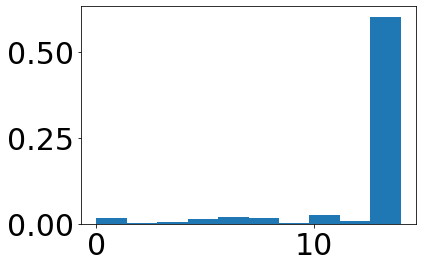

14.0


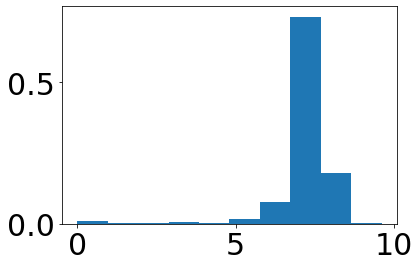

In [45]:
plt.hist(ages,density=True)
plt.show()
print(np.median(ages))

plt.hist(exts,density=True)
plt.show()

In [1]:
plt.figure(figsize=[30,10])
plt.plot(ages)
plt.savefig('LMCAges.pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=[30,10])
plt.plot(exts)
plt.savefig('LMCAk.pdf',bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined

In [22]:
### Functions used in this code
import age_functions as afunc
import extinction as extinct
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons

### Stuff Writtten by A Really Cool Professor
from dlnpyutils import utils as dln

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [23]:
# def closest(val,dat):
#     '''
#     find value closest to the given one
    
#     Inputs:
#     ------
#         val: given value to find/get closest to
#         dat: vals to search through
    
#     Output:
#     ------
#         value in dat closest to val
#     '''
#     #val = np.asarray(val)
#     dat = np.asarray(dat)
    
#     abs_diff = np.abs(dat - val)
#     return dat[abs_diff.argmin()]

def parsec_teff2mag(teff,feh,band,age,isochrones):
    '''
    Calculate the intrinsic magnitude from a star's given temperture and metallicity using PARSEC isochrones
    
    Inputs:
    ------
        teff: temperature of star
        feh: metallicity of star
        band: [str] magnitude
        age: age in Gyr to use 
        isochrones: set of parsec isochrones
    Output:
    ------
        mag: expected intrinsic magnitude for the given temperature
    '''
    
    single = isochrones[np.where((isochrones['logAge']==closest(np.log10(age*10**9),isochrones['logAge']))&
                                 (isochrones['MH']==closest(feh,isochrones['MH'])))]
    
    sidx = np.argsort(single['logTe'])
    slogTe = single['logTe'][sidx]
    smag = single[band][sidx]

    _, ui = np.unique(slogTe,return_index=True)
    
    try:
        if np.log10(teff) > min(slogTe):
            spl = InterpolatedUnivariateSpline(slogTe[ui],smag[ui])
    
            mag = spl(np.log10(teff))
            return mag
        
        else:
            return -9999.0
    
    except:
        return -9999.0
    
def interp_MagAge(mags,ages):
    '''
    Interpolate ages as a function of magnitudes
    
    Inputs:
    ------
        mags: magnitudes
        ages: ages
        
    Outputs:
    -------
        spl: return scipy.interpolate.fitpack2.InterpolatedUnivariateSpline
    '''
    mags = np.asarray(mags)
    ages = np.asarray(ages)
    
    cut = np.where(mags!=-9999.0)
    
    sidx = np.argsort(mags[cut])
    smags = mags[cut][sidx]
    sages = ages[cut][sidx]
    
    try:
        spl = InterpolatedUnivariateSpline(smags,sages)
        return spl
    
    except:
        return -9999.0
    
def absMag(mag,dist,extinction):
    '''
    Calculate the absolute magnitude of a star
    
    Inputs:
    ------
        mag: apparent magnitude of star
        dist: distance in pc
        extinction: extinction in band of interest
        
    Output:
    ------
        amag: absolute magnitude
    '''
    amag = mag-5*np.log10(dist)+5-extinction
    return amag

In [24]:
g_idx = 1000
g_idx2 = 1500

# mag_interpbp = []
# mag_interpg = []
# mag_interprp = []
mag_interpj = []
mag_interph = []
mag_interpk = []

mag_interpj2 = []
mag_interph2 = []
mag_interpk2 = []

for i in tqdm_notebook(10**np.unique(massive['logAge'])/10**9):
#     mag_interpbp.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'G_BPmag',i,massive))
#     mag_interpg.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Gmag',i,massive))
#     mag_interprp.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'G_RPmag',i,massive))
    mag_interpj.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Jmag',i,massive))
    mag_interph.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Hmag',i,massive))
    mag_interpk.append(parsec_teff2mag(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Ksmag',i,massive))
    mag_interpj2.append(parsec_teff2mag(gcs['TEFF'][g_idx2],gcs['FE_H'][g_idx2],'Jmag',i,massive))
    mag_interph2.append(parsec_teff2mag(gcs['TEFF'][g_idx2],gcs['FE_H'][g_idx2],'Hmag',i,massive))
    mag_interpk2.append(parsec_teff2mag(gcs['TEFF'][g_idx2],gcs['FE_H'][g_idx2],'Ksmag',i,massive))
    

# ebprp = (gcs['GAIA_PHOT_BP_MEAN_MAG'][g_idx]-gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]-
#          extinct.parsec_teff2color(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'G_BPmag','G_RPmag',12.5,massive))

# egrp = (gcs['GAIA_PHOT_G_MEAN_MAG'][g_idx]-gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]-
#          extinct.parsec_teff2color(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Gmag','G_RPmag',12.5,massive))

ejh = (gcs['J'][g_idx]-gcs['H'][g_idx]-
       extinct.parsec_teff2color(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Jmag','Hmag',12.5,massive))

ejk = (gcs['J'][g_idx]-gcs['K'][g_idx]-
       extinct.parsec_teff2color(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],'Jmag','Ksmag',12.5,massive))

ejh2 = (gcs['J'][g_idx2]-gcs['H'][g_idx2]-
       extinct.parsec_teff2color(gcs['TEFF'][g_idx2],gcs['FE_H'][g_idx2],'Jmag','Hmag',12.5,massive))

ejk2 = (gcs['J'][g_idx2]-gcs['K'][g_idx2]-
       extinct.parsec_teff2color(gcs['TEFF'][g_idx2],gcs['FE_H'][g_idx2],'Jmag','Ksmag',12.5,massive))

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

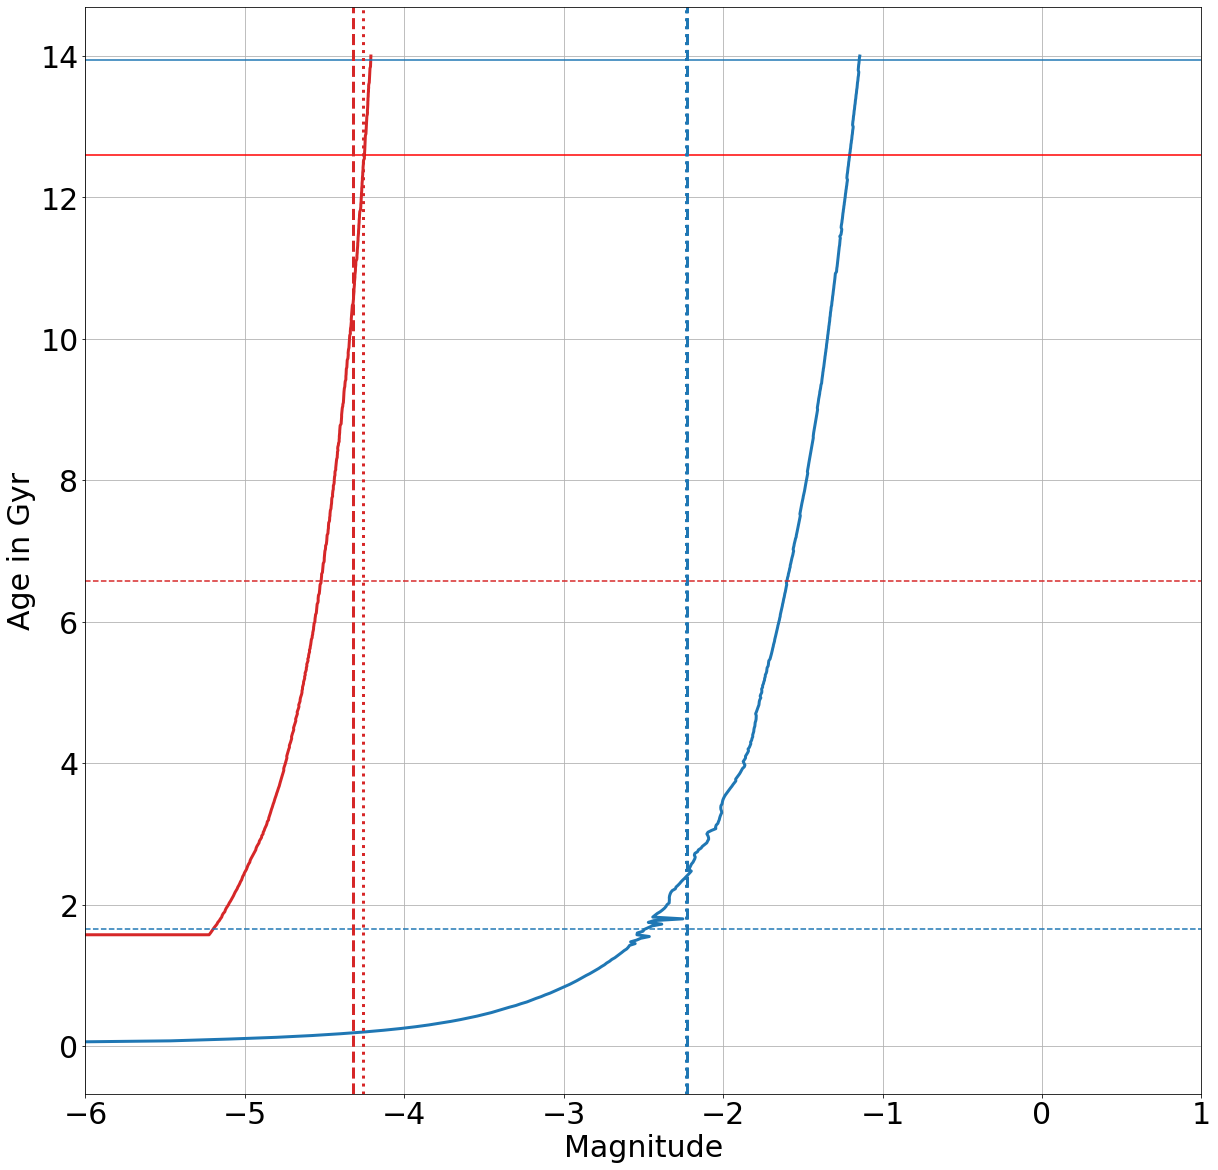

In [31]:
### Denissenkov et al. 2017

# abp_g_idx = ebprp*extinct.cardelli_alav(leff['BP'],3.1)/extinct.cardelli_e12av(leff['BP'],leff['RP'],3.1)
# ag_g_idx = ebprp*extinct.cardelli_alav(leff['G'],3.1)/extinct.cardelli_e12av(leff['G'],leff['RP'],3.1)
# arp_g_idx = ebprp*extinct.cardelli_alav(leff['RP'],3.1)/extinct.cardelli_e12av(leff['BP'],leff['RP'],3.1)
# aj_g_idx = ejh*extinct.cardelli_alav(leff['J'],3.1)/extinct.cardelli_e12av(leff['J'],leff['H'],3.1)
# ah_g_idx = ejh*extinct.cardelli_alav(leff['H'],3.1)/extinct.cardelli_e12av(leff['J'],leff['H'],3.1)
ak_g_idx = ejk*extinct.cardelli_alav(leff['K'],3.1)/extinct.cardelli_e12av(leff['J'],leff['K'],3.1)
ak_g_idx2 = ejk2*extinct.cardelli_alav(leff['K'],3.1)/extinct.cardelli_e12av(leff['J'],leff['K'],3.1)

plt.figure(figsize=[20,20])
# plt.plot(mag_interpbp,(10**np.unique(massive['logAge'])/10**9),label='BP',lw=3.0)
# plt.plot(mag_interpg,(10**np.unique(massive['logAge'])/10**9),label='G',lw=3.0)
# plt.plot(mag_interprp,(10**np.unique(massive['logAge'])/10**9),label='RP',lw=3.0)
# plt.plot(mag_interpj,(10**np.unique(massive['logAge'])/10**9),label='J',lw=3.0)
# plt.plot(mag_interph,(10**np.unique(massive['logAge'])/10**9),label='H',lw=3.0)
plt.plot(mag_interpk,(10**np.unique(massive['logAge'])/10**9),label='K',lw=3.0,c='tab:red')
plt.plot(mag_interpk2,(10**np.unique(massive['logAge'])/10**9),label='K',lw=3.0,c='tab:blue')

plt.axhline(12.6,c='red')
plt.axhline(13.95,c='tab:blue')
plt.axhline(6.58263274,c='tab:red',ls='--')
plt.axhline(1.64998445,c='tab:blue',ls='--')
# plt.legend()
# plt.axvline(gcs['GAIA_PHOT_BP_MEAN_MAG'][g_idx]-15.02-abp_g_idx,c='tab:blue',ls=':',lw=3.0)
# plt.axvline(gcs['GAIA_PHOT_G_MEAN_MAG'][g_idx]-15.02-ag_g_idx,c='tab:orange',ls=':',lw=3.0)
# plt.axvline(gcs['GAIA_PHOT_RP_MEAN_MAG'][g_idx]-15.02-arp_g_idx,c='tab:green',ls=':',lw=3.0)
# plt.axvline(gcs['J'][g_idx]-15.02-aj_g_idx,c='tab:red',ls=':',lw=3.0)
# plt.axvline(gcs['H'][g_idx]-15.02-ah_g_idx,c='tab:purple',ls=':',lw=3.0)
plt.axvline(gcs['K'][g_idx]-15.02-ak_g_idx,c='tab:red',ls=':',lw=3.0)
plt.axvline(gcs['K'][g_idx2]-5*np.log10(6400)+5.0-ak_g_idx2,c='tab:blue',ls=':',lw=3.0)
plt.axvline(gcs['K'][g_idx]-5*np.log10(10400)+5.0-0.02678748,c='tab:red',ls='--',lw=3.0)
plt.axvline(gcs['K'][g_idx2]-5*np.log10(6400)+5.0-0.19425305,c='tab:blue',ls='--',lw=3.0)

plt.xlim(-6,1)
plt.grid()
# plt.title(r'Denissenkov et al. 2017')
plt.xlabel(r'Magnitude')
plt.ylabel(r'Age in Gyr')
plt.show()

In [117]:
gcs['K'][g_idx]-5*np.log10(10400)-5.0#-0.02678748

-14.29816699404029

In [123]:
gcs['K'][g_idx]-5*np.log10(10400)+5.0-0.02678748

-4.3249544740402905